In [62]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

# Display options
pd.set_option("display.max_columns", 50)
sns.set(style="darkgrid")


In [63]:
df = pd.read_csv("traffic_timeseries_FINAL.csv")
df.head()


,time_sec,vehicle_count,average_speed_kmh,density,speed_variance,density_trend,flow_trend
0,0.25,2,21.71,0.2,6875.39,0,434.16
1,0.50,2,30.58,0.2,20800.14,0,611.55
2,0.75,3,33.12,0.3,63724.68,1,993.52
3,1.00,2,14.81,0.2,2829.06,-1,296.11
4,1.25,2,19.21,0.2,0.00,0,384.19


In [64]:
print("shape:", df.shape)
print(df.columns.tolist())
df.info()
df.describe().T


shape: (1312, 7)
['time_sec', 'vehicle_count', 'average_speed_kmh', 'density', 'speed_variance', 'density_trend', 'flow_trend']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312 entries, 0 to 1311
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time_sec           1312 non-null   float64
 1   vehicle_count      1312 non-null   int64  
 2   average_speed_kmh  1312 non-null   float64
 3   density            1312 non-null   float64
 4   speed_variance     1312 non-null   float64
 5   density_trend      1312 non-null   int64  
 6   flow_trend         1312 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 71.9 KB


,count,mean,std,min,25%,50%,75%,max
time_sec,1312.0,164.125000,94.721522,0.25,82.1875,164.125,246.0625,328.00
vehicle_count,1312.0,2.689024,1.622478,0.00,1.0000,2.000,4.0000,8.00
average_speed_kmh,1312.0,15.696791,11.749153,0.00,8.0500,13.360,20.9325,105.68
density,1312.0,0.268902,0.162248,0.00,0.1000,0.200,0.4000,0.80
speed_variance,1312.0,8538.991921,17723.179326,0.00,0.0000,1947.040,8541.1600,215571.11
density_trend,1312.0,0.002287,0.799978,-3.00,0.0000,0.000,0.0000,3.00
flow_trend,1312.0,400.895816,285.823743,0.00,187.2300,357.400,563.9950,2438.50


In [65]:
# convert time column to numeric and sort
df['time_sec'] = pd.to_numeric(df['time_sec'], errors='coerce')
df = df.sort_values('time_sec').reset_index(drop=True)

# Optional: ensure uniform grid. We'll build index from min to max by TIME_STEP
TIME_STEP = 0.25
tmin, tmax = df['time_sec'].min(), df['time_sec'].max()
expected_index = np.round(np.arange(tmin, tmax + TIME_STEP/2, TIME_STEP), 2)

# reindex to uniform grid (fill missing with NaN)
df_uniform = pd.DataFrame({'time_sec': expected_index})
df = df_uniform.merge(df, on='time_sec', how='left')

# forward/backfill small gaps (if any). Be careful: large gaps should be investigated
df[['vehicle_count','average_speed_kmh','density','speed_variance','density_trend','flow_trend']] = \
    df[['vehicle_count','average_speed_kmh','density','speed_variance','density_trend','flow_trend']].ffill().bfill()

df.head(10)


,time_sec,vehicle_count,average_speed_kmh,density,speed_variance,density_trend,flow_trend
0,0.25,2,21.71,0.2,6875.39,0,434.16
1,0.50,2,30.58,0.2,20800.14,0,611.55
2,0.75,3,33.12,0.3,63724.68,1,993.52
3,1.00,2,14.81,0.2,2829.06,-1,296.11
4,1.25,2,19.21,0.2,0.00,0,384.19
5,1.50,1,17.49,0.1,0.00,-1,174.93
6,1.75,2,43.27,0.2,0.00,1,865.33
7,2.00,1,38.42,0.1,0.00,-1,384.19
8,2.25,2,37.92,0.2,60048.40,1,758.42
9,2.50,2,38.97,0.2,56038.21,0,779.39


In [66]:
adf = adfuller(df["vehicle_count"])
print("ADF Statistic:", adf[0])
print("p-value:", adf[1])


ADF Statistic: -5.4394045376821865
p-value: 2.798070491472592e-06


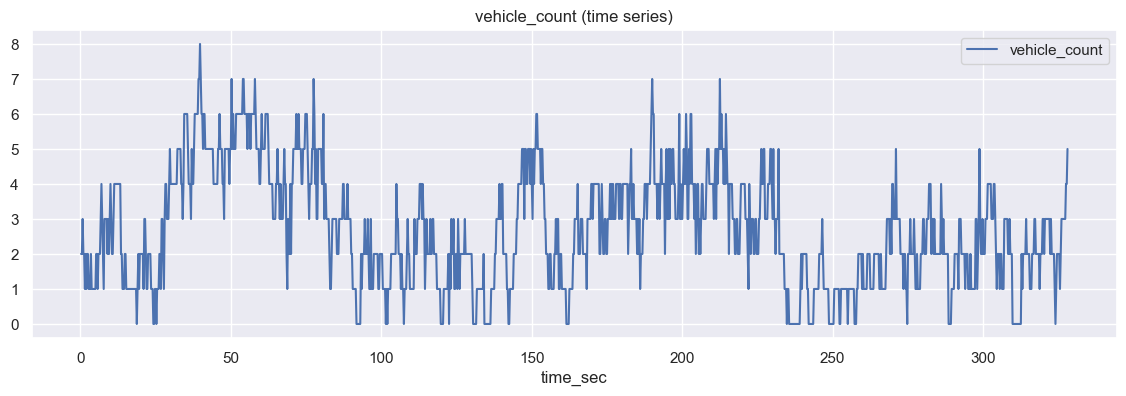

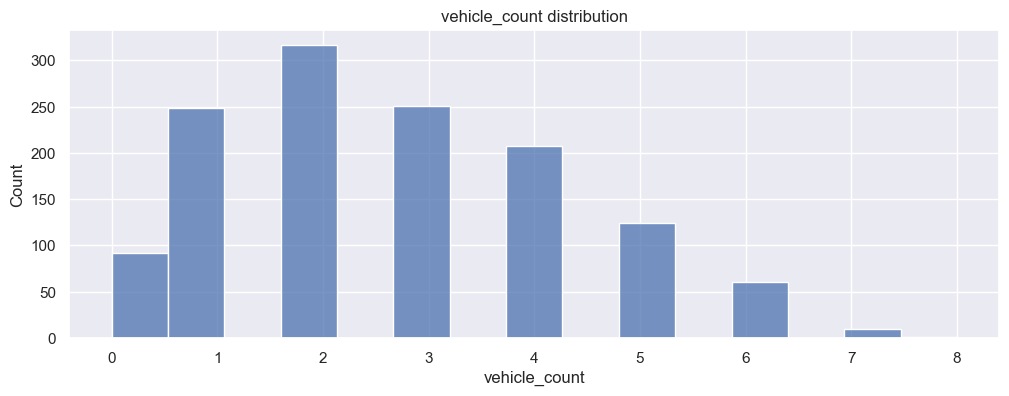

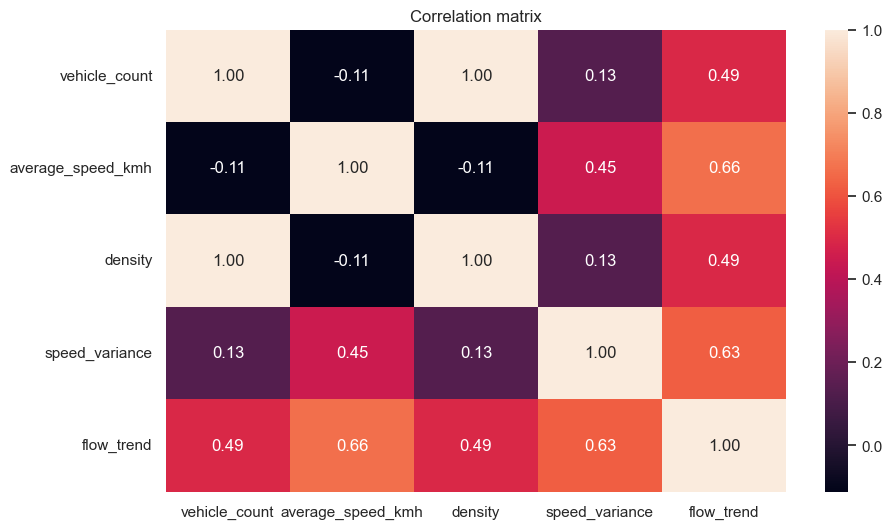

In [67]:
#eda
plt.figure(figsize=(14,4))
plt.plot(df['time_sec'], df['vehicle_count'], label='vehicle_count')
plt.title("vehicle_count (time series)")
plt.xlabel("time_sec")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
sns.histplot(df['vehicle_count'].astype(int), bins=15)
plt.title("vehicle_count distribution")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df[['vehicle_count','average_speed_kmh','density','speed_variance','flow_trend']].corr(), annot=True, fmt=".2f")
plt.title("Correlation matrix")
plt.show()


In [78]:
TARGET = "density"

FEATURES = [
    "vehicle_count",
    "density",
    "density_trend",
    "flow_trend"
]

df = df[["time_sec"] + FEATURES].copy()
df.head()


,time_sec,vehicle_count,density,density_trend,flow_trend
0,0.25,2,0.2,0,434.16
1,0.50,2,0.2,0,611.55
2,0.75,3,0.3,1,993.52
3,1.00,2,0.2,-1,296.11
4,1.25,2,0.2,0,384.19


In [79]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[FEATURES])

scaled_df = pd.DataFrame(scaled, columns=FEATURES)
scaled_df.head()


,vehicle_count,density,density_trend,flow_trend
0,0.250,0.250,0.500000,0.178044
1,0.250,0.250,0.500000,0.250789
2,0.375,0.375,0.666667,0.407431
3,0.250,0.250,0.333333,0.121431
4,0.250,0.250,0.500000,0.157552


In [80]:
import numpy as np

LOOKBACK = 16   # 16 * 0.25s = 4 seconds history

def create_sequences(data, target_index, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback, target_index])
    return np.array(X), np.array(y)

target_idx = FEATURES.index(TARGET)

X, y = create_sequences(scaled, target_idx, LOOKBACK)

X.shape, y.shape


((1296, 16, 4), (1296,))

In [81]:
split = int(0.7 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape


((907, 16, 4), (389, 16, 4))

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(units=64, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=lr),
        metrics=["mae"]
    )
    return model


In [100]:
LOOKBACK = 32   # 32 * 0.25 = 8 seconds history (much better)
HORIZON = 1

def create_sequences(data, target_index, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback, target_index])
    return np.array(X), np.array(y)

target_idx = FEATURES.index(TARGET)

X, y = create_sequences(scaled, target_idx, LOOKBACK)

# 70/30 split (time order)
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.25),

    LSTM(64, return_sequences=False),
    Dropout(0.25),

    Dense(64, activation="relu"),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="huber",   # 🔥 better than MSE for noisy signals
    metrics=["mae"]
)

model.summary()


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 32, 256)        │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_98 (LSTM)                  │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,593 (869.50 KB)

 Trainable params: 222,593 (869.50 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
callbacks = [
    EarlyStopping(patience=12, restore_best_weights=True),
    ReduceLROnPlateau(patience=6, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - loss: 0.0444 - mae: 0.2298 - val_loss: 0.0109 - val_mae: 0.1155 - learning_rate: 0.0010
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.0093 - mae: 0.1117 - val_loss: 0.0085 - val_mae: 0.1029 - learning_rate: 0.0010
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.0080 - mae: 0.1029 - val_loss: 0.0082 - val_mae: 0.1013 - learning_rate: 0.0010
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - loss: 0.0072 - mae: 0.0975 - val_loss: 0.0082 - val_mae: 0.1017 - learning_rate: 0.0010
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 0.0070 - mae: 0.0935 - val_loss: 0.0075 - val_mae: 0.0977 - learning_rate: 0.0010
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 0.0064 - mae: 0.0910 - val_loss: 0.0074 - val_mae: 0.0972 - learning_rate: 0.0010
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0056 - mae: 0.0837 - val_loss: 0.0078 - val_mae: 0.0995 - learning_rate: 0.001

In [107]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MAE = mean_absolute_error(y_test_real, y_pred_real)
RMSE = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
R2 = r2_score(y_test_real, y_pred_real)

print("📊 FINAL LSTM PERFORMANCE")
print("MAE :", MAE)
print("RMSE:", RMSE)
print("R²  :", R2)


📊 FINAL LSTM PERFORMANCE
MAE : 0.048043172210837995
RMSE: 0.06497410729721104
R²  : 0.6427849445898348


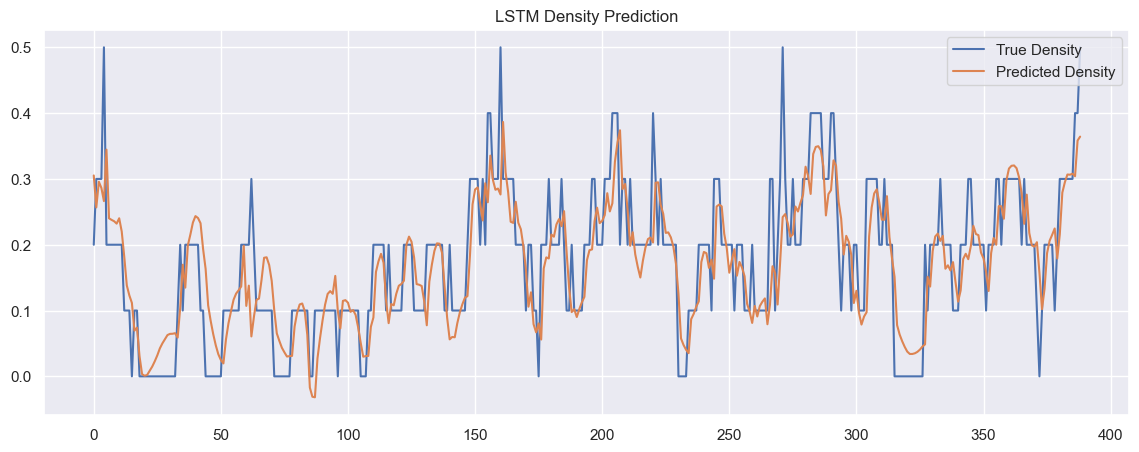

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test_real, label="True Density")
plt.plot(y_pred_real, label="Predicted Density")
plt.legend()
plt.title("LSTM Density Prediction")
plt.show()
